### Projekt: Klasyfikacja obrazów z wykorzystaniem modelu VGG16 oraz analiza zbioru obrazów
### Autor: Kamil Skoczylas
### Studia podyplomowe Data Science 2021-2022, Uniwersytet Ekonomiczny we Wrocławiu



 

# STRUKTURA PROJEKTU 

 1. WPROWADZENIE
 2. DOBÓR MODELU
 3. PRZEDSTAWIENIE I PRZYGOTOWANIE DANYCH
 4. PROCES GENEROWANIA TAGÓW
 5. ANALIZA TAGÓW
 6. ZASTOSOWANIE METOD W PRAKTYCE
 7. PODSUMOWANIE

# 1. WPROWADZENIE

Computer vision jest dynamicznie rozwijającą się dziedziną data science. Na codzień modele tej klasy wykorzystywane są w wielu rozwiązaniach technologicznych takich jak m.in. Obiektyw Google, Face Id, Tesla Autopilot i wiele innych. Niewykluczone że algorytmy tego typu odegrają dużą rolę w automatyzacji powtarzalnych zadań polegajacych na przetważaniu obrazu przez ludzki mózg i przekształceniu społeczeństwa jakie znamy.

Poniższy projekt nakierowany będzie jednak na rozwiązanie innego problemu związanego z rozwojem cywilizacji - stale rosnącej ilości zdjęć w pamięci naszych urządzeń. 
Robienie zdjęć oraz chwilowa ekscytacja uchwyconą chwilą jest przyjemna - problem pojawia się w momencie, gdy zdjęć mamy tysiące, a chcemy szybko odnaleźć zdjęcie o którym właśnie myslimy - wiemy co na nim jest, jednak ginie ono pośród tysięcy innych. 

Rozwiązaniem tego problemu może być zastosowanie modeli klasyfikacji obrazu w celu stworzenia bazy danych. 
W wyniku tego zabiegu użytkownik po wprowadzeniu tagów będzie w stanie wyfiltrować tematy zdjęć, które go interesują. Informacja płynąca z tagów powinna być wystarczająca, aby odnaleźć zdjęcie.

Pierwotna koncepcja na projekt skupiała się na wykorzystaniu zestawu danych Flicker 8k, który zawiera obrazy oraz opisy tych obrazów do zbudowania własnego modelu sieci neuronowych. Niestety nie został osiągnięty oczekiwany efekt. 
W związku z tym postanowiono o zastosowaniu do klasyfikacji wytrenowanego już modelu VGG19 i jego implementacji w bibliotece tensorflow. 

Ogólne opisy poszczególnych modułów zostały napisane w języku polskim, komentarze do kodu natomiast w języku angielskim. 

In [1]:
# IMPORTING NECESSARY PACKAGES
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.utils import plot_model
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.applications.vgg19 import decode_predictions
import os
import sys
import PIL
from PIL import Image
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpi
import os.path
import string
import random
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from PIL import Image, ImageDraw, ImageFont
from pandas_profiling import ProfileReport



In [2]:
# SET UP A DIRECTORY PATH FOR YOU FOLDER WITH IMAGES
dirPathG = 'C:/Users/Kamil/OneDrive/Desktop/Projekty machine-learnign/00_Projekt_tagowanie_obrazów/Flicker8k_Dataset'
print(dirPathG)

C:/Users/Kamil/OneDrive/Desktop/Projekty machine-learnign/00_Projekt_tagowanie_obrazów/Flicker8k_Dataset


#  2. DOBÓR MODELU

Dobór modelu, który pomoże w oznaczaniu zdjęć był jednym z pierwszych wyzwań tego projektu.  

Pod uwagę brane były warianty modeli ResNet, Inception, EfficientNet. Zadecydowano jednak o wyborze sprawdzonego modelu, którym jest VGG19. Każdy ze wskazanych powyżej modeli posiada implementację w bibliotece tensorflow. 

Skuteczność klasy modeli VGG potwierdzają liczne publikacje jak oraz konkursy m.in ImageNet Large Scale Visual Recognition Challenge 2014.
Modele te bazują na architekturze konwolucyjnych sztucznych sieci neuronowych. Pomysłodawcami architektury byli Karen Simonyan i Andrew Zisserman stoważyszeni pod Visual Geometry Group - tworem funkcjonującym w ramach wydziału Inżynierii Uniwersytetu Oksfordzkiego. 


#### Porównanie modeli

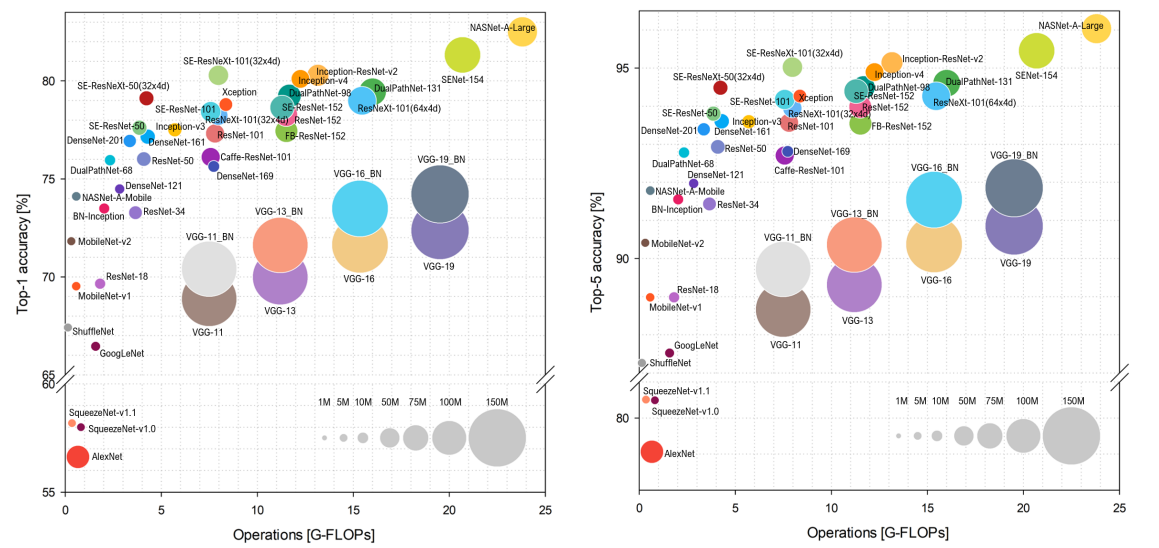

##### Źródło: Benchmark Analysis of Representative Deep Neural Network Architectures, S. BIANCO, R. CADENE, L. CELONA, P. NAPOLETANO [https://arxiv.org/pdf/1810.00736.pdf]


Wyniki na powyższym rysunku zostały uzyskane przez modele na zestawie testowym ImageNet-1k. 
 - Oś pionowa - precyzja klasyfikacji 
 - Oś pozioma - G-FLOPs (milard zmiennoprzecinkowych operacji 'FLOPs')
 - Wielkość okręgów - liczba parametrów modelu. 

Ze względu na dużą liczbę przypadków, które mogą wystąpić na zdjęciach, większa liczba parametrów powinna przekładać się na uniwersalność modelu. W związku z tym, modelem który został użyty w projekcie został VGG19. 

https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19/VGG19

In [3]:
#SETTING UP MODEL 
modelVGG = tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [7]:
modelVGG.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Model VGG19 jest rozwinięciem VGG16, liczby 16 oraz 19 odpowiadają za liczbę warstw wag - na powyższym rysunku Conv2D oraz Dense. 
Inputshape modelu to (none - batch, 224 - wysokość, 224 - szerokość, 3 - liczba kanałów koloru "RGB") macierz trójwymiarowa.
Charakterystyczne dla modeli VGG (Visual Geometry Group) przeplatanie warstw konwolucyjnych z poolingowymi mają na celu wychwytywanie coraz bardziej skomplikowanych cech obrazu w kolejnych warstwach.

# 3. PRZEDSTAWIENIE I PRZYGOTOWANIE DANYCH

Na potrzeby przedstawienia projektu wykorzystany zostanie zbiór obrazów z datasetu Flicker8k. Zbiór zawiera nieco ponad 8 tys. obrazów. Zdjęcia są już skompresowane i wypłaszczone do jednego folderu. 
W analizie własnych zdjęć taki stan rzeczy raczej nie wystąpi, dlatego projekt zawiera w sobie te 2 dodatkowe moduły do pracy z nieustandaryzowanym zestawem danych (przeniesienie wszystkich zdjęć z danego folderu do jednej lokalizacji oraz compresję tych zdjęć).

### ZBIERANIE ZDJĘĆ Z PODFOLDERÓW

In [32]:
# COLLECTING PHOTOS FROM ALL SUBFOLDERS INTO A NEW ONE

# creates new directory if not exists for given directory path and folder name
def create_path(dirPath, folderName):
    folderPath = dirPath +'/'+ folderName
    if os.path.exists(folderPath) == False:
        os.makedirs(folderPath)
    return folderPaths

# generates one random letter (used for avoiding dupliacte names in dataset)
def random_letter():
    randomLetter = random.choice(string.ascii_letters)
    return randomLetter

# unpack all jpg's into new folder. New folder is created on level before the pathToUnpack 
def unpack_levels(pathToUnpack, newFolderName, fileType = '.jpg'):      #this function can be used for other filetypes
    newPath = create_path(os.path.dirname(pathToUnpack), newFolderName) 
    count = 0                                                           #counting to create unique names
    countG= 0
    for i in os.walk(pathToUnpack):                                     #get list of all sub dirs  
        count += 1 
        countG += 1 
        print(i[0])
        for file in os.listdir(i[0]):                                   #loop through items in sub dir 
            filename = os.fsdecode(file)
            if filename.endswith(fileType): 
                countG += 1 
                pathA = i[0] + '/' + filename
                #to avoid the same numbers of images
                randPart = str(count) + random_letter() + str(countG) + random_letter()
                randName =  randPart + filename 
                pathB = i[0] + '/' + randName
                os.rename(pathA, pathB)
                pathC = newPath + '/' + randName
                shutil.copyfile(pathB, pathC)
                
                clear_output(wait=True)
                display('Processed: ' + str(countG)+ ' files <-- ' + str(filename))
            
    a = os.path.dirname(pathToUnpack)
    return a


# USE OF THE ABOVE FUNCTIONS

pathToUnpack = dirPathG
newFolderName = 'COLLECTED_JPGs'

unpack_levels(pathToUnpack, newFolderName)

'Processed: 4322 files <-- wszsw_00006.jpg'

'C:/Users/Kamil/OneDrive/Desktop/Projekty machine-learnign/00_Projekt_Opisywanie obrazów'

### KOMPRESJA ZDJĘĆ 

W celu optymalnej pracy na zdjęciach, po przygotowaniu zestawu zdjęć, pomocne będzie ich skompresowanie.

In [35]:
# creates new directory if not exists for given directory path and folder name
def create_path(dirPath, folderName):
    folderPath = dirPath +'/'+ folderName
    if os.path.exists(folderPath) == False:
        os.makedirs(folderPath)
    return folderPath

# compress single image
def compress_img(theDir, compDir, fileName, verbose = False):
    filepath = str(theDir) + '/' + str(fileName)
    compFilepath = str(compDir)+ '/' + 'Compressed_' +str(fileName)
    picture = Image.open(filepath)
    picture.save(compFilepath, "JPEG", optimize = True, quality = 30)
    return 

# compress whole dir and return its path
def compress_dir(dirPath, fileType = '.jpg'):
    compDirName = "CompressedPhotos"
    compDirectory = create_path(dirPath, compDirName)
    count = 0
    for file in os.listdir(dirPath):
        filename = os.fsdecode(file)
        if filename.endswith(fileType): 
            filenameStr = str(filename)
            compress_img(dirPath, compDirectory, filename)
            count += 1
            clear_output(wait=True)
            display('Compressed: ' + str(count)+ ' files <-- ' + str(filename))
            continue
        else:
            continue
    return compDirectory

compressDir =  compress_dir(dirPathG) #this value is required for further usage
print('CompressedPath: '+compressDir)  

'Compressed: 4275 files <-- 8Z2816u2808m8c2827v2819V8l2814T8Ezdjecia_00002.jpg'

CompressedPath: C:/Users/Kamil/OneDrive/Desktop/Projekty machine-learnign/00_Projekt_Opisywanie obrazów/testy/CompressedPhotos


#  4. PROCES GENEROWANIA TAGÓW

Macierz pikseli RGB jest matematyczną reprezentacją obrazu jaki widzimy ludzkim okiem. Modele uczenia maszynowego do analizy obrazów oparte o sieci konwolucyjne przepuszają przez swoją strukturę macierze pikseli. Na potrzeby projektu wybrany został model VGG19, który jest modelem stworzonym do klasyfikacji obrazów z pewnym prawdopodobieństwem. Modele tego typu w kolejnych warstwach wychwytują coraz bardziej skomplikowane cechy obrazu (features). Ciekawym ćwiczeniem na sprawdzenie, która warstwa odpowiada za jakie cechy jest odcinanie warstw modelu od tyłu i analiza cech wygenerowanych przez poszczególne warstwy.  
Poniżej przedstawiony został proces generowania tagów z użyciem wytrenowanego już modelu VGG19, którego opis został zawarty w 2. DOBÓR MODELU.

In [14]:
# GENERATING TAGS FOR IMAGES IN DIRECOTRY

    
def compress_img(theDir, compDir, fileName, verbose = False):
    filepath = str(theDir) + '/' + str(fileName)
    compFilepath = str(compDir)+ '/' + 'Compressed_' +str(fileName)
    picture = Image.open(filepath)
    picture.save(compFilepath, "JPEG", optimize = True, quality = 30)
    return 
    
# generate list of tags for model(VGG19) and filepath
def generate_tags(model, filepath):
    img = image.load_img(filepath, target_size = (224, 224))    #load and resize 
    imgTransformed = image.img_to_array(img)                    #convert into array
    imgTransformed = np.expand_dims(imgTransformed, axis = 0)   #insert a new axis that will appear at the axis position in the expanded array shape
    imgTransformed = preprocess_input(imgTransformed)           #adding batch dimension
    prediction = model.predict(imgTransformed)                  #applying model for prediction 
    predictionLabel = decode_predictions(prediction, top = 10)  #decoding top 10 predictions of what is this image
    filename = os.path.basename(filepath)                       #getting name of file
    tagList = []                                                #creating list object
    for i in range(len(predictionLabel[0])):                    #looping through predictions 
        #predictionLabel[0][i][0] = filename     
        imgTagList = [filename]                                 #create or overwrite imgTagList list
        imgTagList.extend(predictionLabel[0][i][1:])            #add predicted class and it's probability to the list(extend it)
        tagList.append(imgTagList)                              #add list(filename, class, prediciton_prob) as list element
    return tagList                                              #return all appened imgTagList lists for the file

# generate dataframe of tags for photos in a dir of compressed photos
def generate_tags_dir(model ,compDirPath, fileType = '.jpg'):
    count = 0
    dfTags = pd.DataFrame(columns = ['imgName', 'tags', 'tagProb'])          #creating dataframe shema
    for file in os.listdir(compDirPath):                                     #looping through 
        filename = os.fsdecode(file)                                         #getting filename
        filePath = compDirPath + '/' +filename                               #creating full filepath
        if filename.endswith(fileType):                                      #only jpg's 
            tagList = generate_tags(model, filePath)                         #each time overwriting tagList list
            for i in range(len(tagList)):                                    #loop through predictions for the file
                dfTags.loc[len(dfTags)] = tagList[i]                         #add each list(filename, class, prediciton_prob) as df row
            count += 1
            clear_output(wait=True)
            display('Tagged: ' + str(count)+ ' files <-- ' + str(filename))
            continue
        else:
            continue
    return dfTags

#comment when using the part with compression
compressDir = dirPathG 
#generating dataframe of tags
dfFullTags = generate_tags_dir(modelVGG, compressDir)
                                                      
#saving dataframe to csv for futher use
file_name = 'ImageTags'
dfFullTags.to_csv(compressDir +'/'+ file_name, index=False)


'Tagged: 8091 files <-- 997722733_0cb5439472.jpg'

# 5. ANALIZA TAGÓW

Po procesie ekstrakcji i zapisu tagów zdjęć przyszła pora na zapoznanie się z danymi. 
W tej cześci przewiajć się będzie stworzony wcześniej dataframe, który składa się z 3 kolumn:
1. Nazwa obrazu
2. Tagi 
3. Prawdopodobieństo klasyfikacji

Wpisów w dataframe będzie kilkukrotnie więcej, ponieważ pojedyńcze zdjęcie może mieć przypisane kilka tagów.

In [3]:
#LOADING THE TAG DATAFRAME

compressDir = dirPathG  #comment when using the part with compression

tagsFilePath = compressDir +'/ImageTags' 
dfTags = pd.read_csv(tagsFilePath)

dfTags

imgName                tags   tagProb
0      1000268201_693b08cb0e.jpg              apiary  0.422245
1      1000268201_693b08cb0e.jpg                 pot  0.073056
2      1000268201_693b08cb0e.jpg                yurt  0.072007
3      1000268201_693b08cb0e.jpg          greenhouse  0.063105
4      1000268201_693b08cb0e.jpg               crate  0.035839
...                          ...                 ...       ...
80905   997722733_0cb5439472.jpg               wreck  0.024888
80906   997722733_0cb5439472.jpg                pole  0.021888
80907   997722733_0cb5439472.jpg  long-horned_beetle  0.018064
80908   997722733_0cb5439472.jpg           parachute  0.017463
80909   997722733_0cb5439472.jpg            umbrella  0.016304

[80910 rows x 3 columns]

In [4]:
profile_report = ProfileReport(dfTags, minimal=True)
profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Raport wygenerowany przez pandas-profiling dostarcza podstawowych informacji na temat wygenerowanej tabeli nazw zdjęc, tagów i prawdopodobieństw. Najważniejsze wnioski płynące z raportu to:
- Zdjęcia: liczba zdjęc to 8091; liczba wpisów w pliku to 80860 (~10 tagów per obraz)
- Tagi: liczba unikalnych tagów to 964; łączna liczba wpisów tagów to 76492 (częśc wpisów jest pusta)
- Prawdopodobieństwa: 95% prawdopodobieństw jest poniżej 0.3862; cztery prawdopodobieństwa szacunku równe 1, są one jednoczeście najczęściej występującą wartością(4 razy); histogram wygląda na prawoskośny, natomiast nie jest spełniony warunek średnia(0.0796)>mediana(0.0273)>moda(1) ponieważ moda jest nawyższą wartością w rozkładzie. 


Łączna liczba wygenerowanych tagów nie mówi zbyt wiele ich przydatności. 
W rzeczywistości to użytkownik powinien mieć możliwość kontroli jakie prawdopodobieństwo klasyfikacji jest w stanie zaakceptować. 
Poza prawdopodobieństwem pod uwagę mogą być brane również liczba unikalnych tagów oraz całkowita liczba tagów. 
Do wyznaczenia optymalnego poziomu minimlanego prawdopodobieństwa szacunku wykorzystana zostanie następująca koncepcja:  


$ \hat{TS}_{p_{min}} = {P}_{min} * {TT}_{p_{min}} $

$ \hat{OTS}_{p_{min}} = {Max(}\hat{TS}_{p_{min}} {)} $

Gdzie: 
- $ \hat{TS}_{p_{min}} $  - teoretyczna przydatność klasyfiakcji zbioru obrazów dla minimalnego prawdopodobieństwa klasyfikacji
- $ {P}_{min} $           - minimalne prawdopodobieństwo klasyfikacji
- $ {TT}_{p_{min}} $  - liczba tagów o prawdopodobieństwie klasyfikacji większym niż $ {p_{min}} $
- $ \hat{OTS} $ - maksymalna teoretyczna przydatność klasyfiakcji zbioru obrazów dla zadanego zestawu prawdopodobieństw

W wyniku wyboru maksymalnej wartości iloczynu minimalnego prawdopodobieństwa szacunku oraz łącznej liczby tagów dla tego prawdopodobieństwa otrzymujemy maksymalną trafność szacunku dla danego zestawu tagów. 

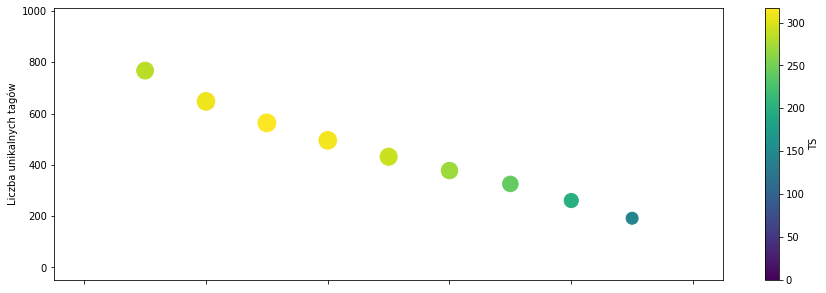

In [9]:
# printing out possible tags based on some parameters
def all_tags(df, minProbablity, columnNameToList = 'tags'):
    df2 = df[df['tagProb'] > minProbablity]
    uniqueList = df2[columnNameToList].tolist()                           # convert required column values to list
    return uniqueList

def possible_tags(df, minProbablity, columnNameToList = 'tags'):
    df2 = df[df['tagProb'] > minProbablity]
    uniqueList = df2[columnNameToList].tolist()                           # convert required column values to list
    uniqueList = np.unique(uniqueList)                                    # get unique values from list
    return uniqueList

def records_per_prob(dfTags, step):
    prob = 0
    probDf = pd.DataFrame(columns = ['minProb', 'uniqueTags', 'allTags'])

    while prob <= 1:
        
        uniqTagListNum =  possible_tags(dfTags, prob).shape[0]
        allTagListNum = len(all_tags(dfTags, prob))
        
        probList = [prob, uniqTagListNum, allTagListNum]
        probDf.loc[len(probDf)] = probList 
        
        prob += step
        prob = round(prob,2)
    return probDf
        
step = 0.1
probDf = records_per_prob(dfTags, step)

probDf['TS'] = probDf["allTags"]*probDf["minProb"]/5
    
def plot_prob(DataFrame):
    df = DataFrame
    chart = df.plot.scatter(xlabel='Minimalne prawdopodobieństwo szacunku'
                            , ylabel='Liczba unikalnych tagów'
                            , x='minProb' 
                            , y='uniqueTags' 
                            , s = 'TS'
                            , colormap='viridis'
                            , c = 'TS' 
                            , figsize=(15,5))
    
plot_prob(probDf)    


In [242]:
probDf

minProb  uniqueTags  allTags      TS
0       0.0       964.0  80910.0    0.00
1       0.1       768.0  14183.0  283.66
2       0.2       648.0   7728.0  309.12
3       0.3       564.0   5284.0  317.04
4       0.4       496.0   3895.0  311.60
5       0.5       432.0   2912.0  291.20
6       0.6       378.0   2258.0  270.96
7       0.7       326.0   1723.0  241.22
8       0.8       261.0   1255.0  200.80
9       0.9       192.0    802.0  144.36
10      1.0         0.0      0.0    0.00

In [241]:
probDf.describe()

minProb  uniqueTags       allTags          TS
count  11.000000   11.000000     11.000000   11.000000
mean    0.500000  457.181818  10995.454545  215.450909
std     0.331662  272.898816  23535.641680  118.567008
min     0.000000    0.000000      0.000000    0.000000
25%     0.250000  293.500000   1489.000000  172.580000
50%     0.500000  432.000000   2912.000000  270.960000
75%     0.750000  606.000000   6506.000000  300.160000
max     1.000000  964.000000  80910.000000  317.040000

Maksymalna wartość trafności szacunku jest uzyskiwana dla $ p > 0.3 $

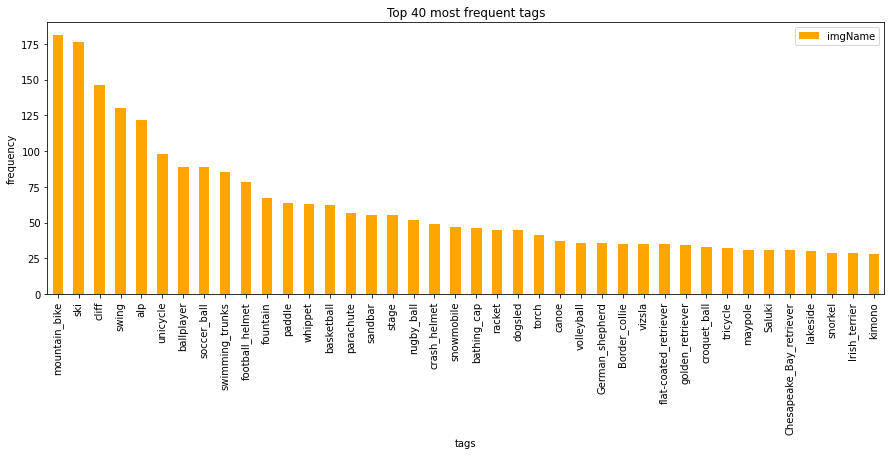

In [149]:
# top X most frequenty occuring tags

def frequency(df, columnNameToList = 'tags', minProbablity = 0.3):
    df2 = df[df['tagProb'] > minProbablity]
    df2 = df2[['imgName','tags']].copy()
    dfFrequency= df2.groupby(by="tags", dropna=False).count()
    return dfFrequency

def plot_frequency(dfFrequency, top_most_least, numOfBars):
    df = dfFrequency 
    fig = df.head(numOfBars).plot.bar(color = 'orange'
                                      , figsize=(15,5)
                                      , ylabel = 'frequency' 
                                      , xlabel = 'tags' 
                                      , title = 'Top %s %s frequent tags' % (numOfBars, top_most_least))



dfFrequencyDesc = frequency(dfTags).sort_values(by="imgName", ascending = False)
plot_frequency(dfFrequencyDesc, top_most_least = 'most', numOfBars = 40)

Powyższy wykres pokazuje top x tagów, które występują okreśłonym wcześniej dataframe. 
Pozwala to określić jakie tematy/tagi przewijają się przez galerię najczęściej. Z tego wynika np. że w zestawie danych dużą część stanowi turystyka na którą składają się między innymi (top 5) rowery, narty, zbocza(clify), chuśtawki, góry. 


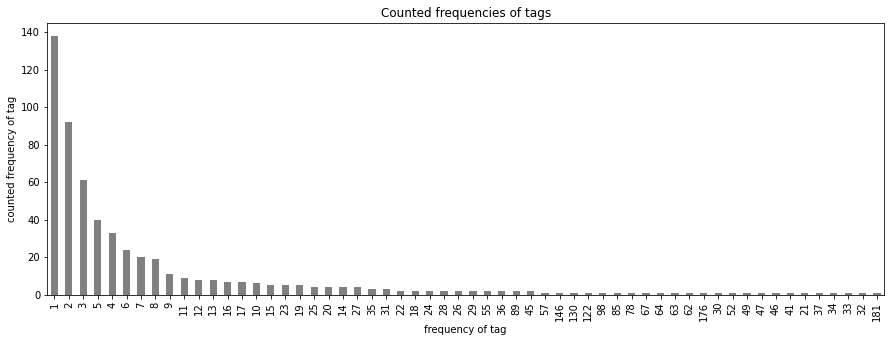

In [154]:
def plot_frequency_count(dfFrequency):
    df = dfFrequency.imgName.value_counts()
    fig = df.plot.bar(color = 'gray'
                      , figsize=(15,5)
                      , ylabel = 'counted frequency of tag' 
                      , xlabel = 'frequency of tag'
                      , title = 'Counted frequencies of tags')

plot_frequency_count(dfFrequencyDesc)

Powyższy wykres ilustruje liczbę wystąpień ilości tagów. Wynika z tego, że 
 - jest niemal 140 tagów, ktore są unikalne i występują tylko raz, 
 - nieco ponad 90 tagów, które występują 2 razy. 
 - około 60 tagów, które występują 3 krotnie w analizowanym dataframe itd. 
 
Na drugim końcu osi x widać liczbę tagów, których krotność występowania jest niska.

Dalsza część projektu skupiać się będzie na wykorzystaniu dotychczas wypracowanych metod. Na początek przedstawione zostaną kolaże zdjęć zawierających tagi o najwyższym prawdopodobieństwie, następnie te o najniższym, przy czym najniższe prawdopodobieństwo jest rozumiane jakio minimalne prawdopodobieństwo szacunku akceptowane przez użytkownika modelu. Próba oszacowania tego prawdopodobieństwa przedstawione we wcześniejszej części projektu wskazuje jego wartość na poziomie 0.3. 

                         imgName             tags   tagProb
37790  3036641436_d6594fc45f.jpg            swing  1.000000
52200  3351704877_28dea303aa.jpg    Arabian_camel  1.000000
54500  3402081035_a54cfab1d9.jpg        parachute  0.999999
540     107318069_e9f2ef32de.jpg          balloon  0.999999
50010  3310551665_15b79ef4ea.jpg           bubble  0.999997
18100   241347803_afb04b12c4.jpg  football_helmet  0.999993
20390  2479553749_f7ac031940.jpg         carousel  0.999987
61610  3539767254_c598b8e6c7.jpg          gondola  0.999980
38320  3048380686_732db55281.jpg             puck  0.999978
47670  3259666643_ae49524c81.jpg       basketball  0.999964
31120  2852982055_8112d0964f.jpg         fountain  0.999930
30390  2831217847_555b2f95ca.jpg             jeep  0.999926
56460  3437654963_c4fdc17e8b.jpg       brown_bear  0.999911
900     109738916_236dc456ac.jpg       snowmobile  0.999909
45700   322050103_145f7233c6.jpg    traffic_light  0.999884
37600  3030824089_e5a840265e.jpg  German

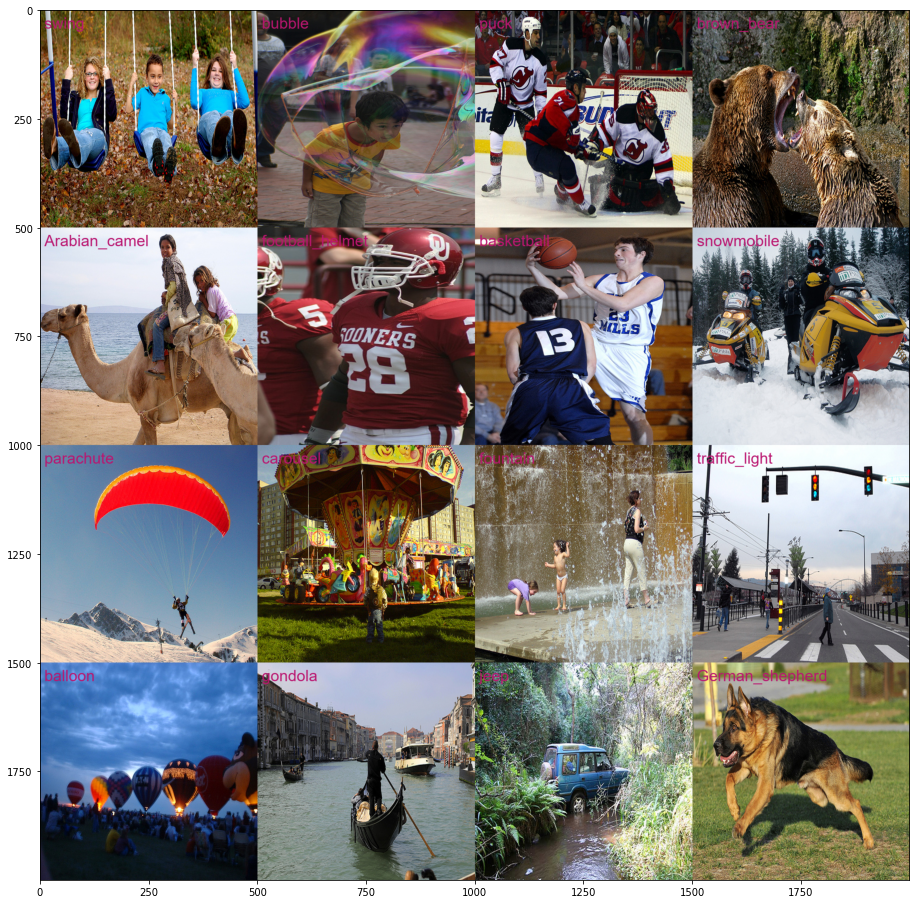

In [83]:
# top X highest prob predictions 

dfTopProb = dfTags.copy()
dfTopProb['tagProb'] = dfTopProb['tagProb'].map('{:,.6f}'.format)
dfTopProb = dfTopProb.sort_values(by="tagProb", ascending = False)


# basicly building collage from the df that was used in the project
# the df has to have at least x times y rows
#df - dataframe 
#distinct_tags - 1 if dont want the same tages
#xImgNum - number of images on x axis 
#yImgNum - number of images on y axis
#x_width - width of single image
#y_height - height of single image
def collage_df(df, distinct_tags = 1, xImgNum = 4, yImgNum =4, x_width =500, y_height = 500):
    #setting up dfTemp
    dfTemp = df
    if distinct_tags == 1:
        dfTemp = dfTemp.drop_duplicates('tags')
    
    #setting up number of images
    xy = xImgNum*yImgNum
    imgList = dfTemp['imgName'].head(xy).tolist()  
    imgTagList = dfTemp['tags'].head(xy).tolist()  

    collage = Image.new("RGBA", (x_width*xImgNum,y_height*yImgNum), color=(255,255,255,255))

    font = ImageFont.truetype("arial.ttf", size=36)

    c=0
    for x in range(0, xImgNum*x_width, x_width):
        
        for y in range(0,yImgNum*y_height, y_height):
            
            file =  dirPathG +"/"+str(imgList[c])
            photo = Image.open(file).convert("RGBA")
            photo = photo.resize((x_width, y_height))  
            #captioning photos
            I1 = ImageDraw.Draw(photo)
            I1.text((10, 10), imgTagList[c], font = font, fill=(186, 22, 112))

            collage.paste(photo, (x,y))
            c+=1


    fig = plt.figure(figsize=(xy, xy))
    print(dfTemp.head(xy))
    plt.imshow(collage)


collage_df(dfTopProb)


                         imgName                   tags   tagProb
47130  3250076419_eb3de15063.jpg                basenji  0.300141
43880  3183777589_460a4f445b.jpg                 basset  0.300160
20590  2486364531_b482d7f521.jpg             lawn_mower  0.300224
30720  2838619742_eed855d8a8.jpg    Rhodesian_ridgeback  0.300246
22170  2543017787_9720b4fa1c.jpg                   coil  0.300291
51151  3334866049_f5933344aa.jpg                    ski  0.300295
32461  2883907436_82bf4a36b8.jpg          Gordon_setter  0.300349
63150  3568197730_a071d7595b.jpg               unicycle  0.300358
52541  3357416302_fcfcdd7b86.jpg                    alp  0.300377
1760   1213336750_2269b51397.jpg         triumphal_arch  0.300409
77890   611910909_4f8e43e070.jpg         indigo_bunting  0.300433
27531   271637337_0700f307cf.jpg                 collie  0.300458
47320  3255017708_2b02bfcdcf.jpg                gondola  0.300491
64811  3603870481_1ebc696d91.jpg  flat-coated_retriever  0.300497
37160  301

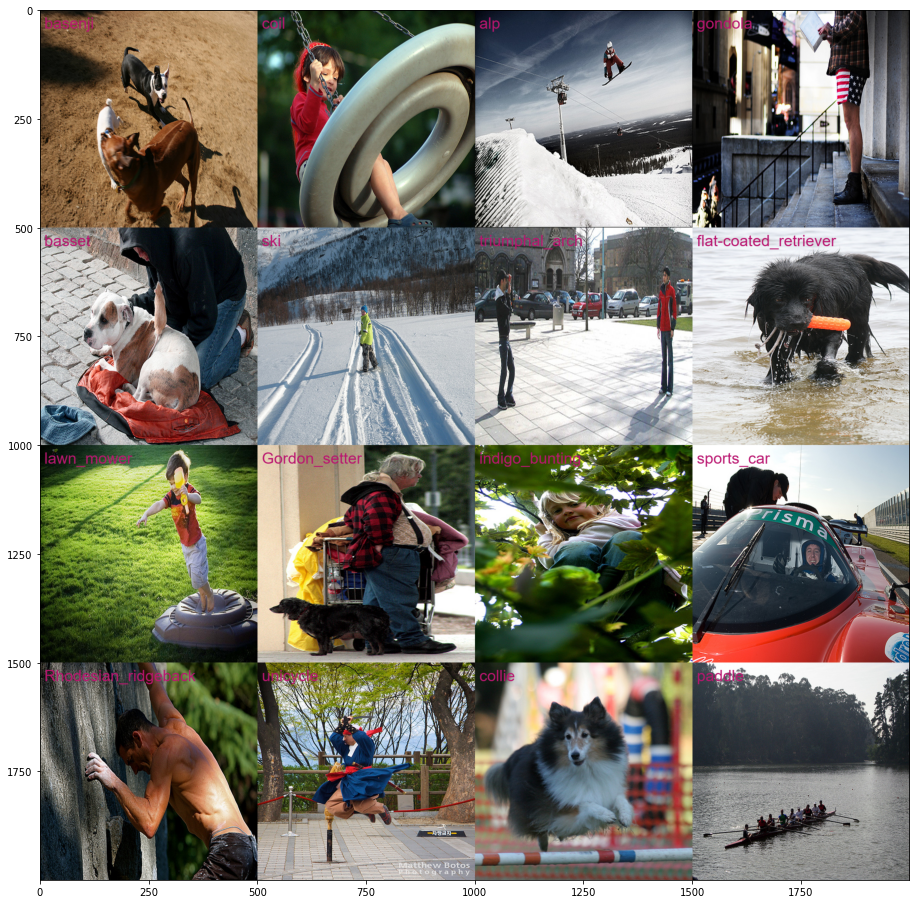

In [86]:
# top 20 lowest prob predictions 
minProbablity = 0.3
dfLowProb = dfTags.copy()
dfLowProb = dfLowProb[dfLowProb['tagProb'] > minProbablity]
dfLowProb['tagProb'] = dfLowProb['tagProb'].map('{:,.6f}'.format)
dfLowProb = dfLowProb.sort_values(by="tagProb", ascending = True)

collage_df(dfLowProb)

#zrobić kolarz zdjęć 

Wygenerowanie kolaża zdjęć o różych (niskich i wysokich) prawdopodobieństwach tagów pozwala zobrazować (choć w malej skali) że nawet tagi o niskim prawdopodobieństwie potrafią być pomocne. Z drugiej strony jednak w przypadku wybrania zbyt niskiego minimalnego akceptowalnego prawdopodobieństwa użytkownik zostanie zalany masą błędnych informacji. Powyższe wskazuje zatem, że przy korzystaniu z podobnych modeli, należy poświęcić duża uwagę na dobór parametrów. 

# 6. ZASTOSOWANIE METOD W PRAKTYCE

Poniżej zaprezentowana została lista dostępnych do wykorzystania tagów w ramach testowanego rozwiązania tak jak zostało to na początku projektu zdefiniowane tj. do przeszukiwania galerii na podstawie tagów, które zostały przypisane do obrazów wewnątrz tej galerii.  
Na początek wygenerowana zostanie lista dostępnych dla użytkownika tagów.

In [10]:
# all availible tags 

tagList = possible_tags(dfTags, minProbablity = 0.3, columnNameToList = 'tags' )
tagList

array(['Afghan_hound', 'African_crocodile', 'African_elephant',
       'African_grey', 'African_hunting_dog', 'Airedale',
       'American_Staffordshire_terrier', 'American_alligator',
       'American_black_bear', 'American_chameleon', 'American_coot',
       'American_egret', 'Angora', 'Appenzeller', 'Arabian_camel',
       'Arctic_fox', 'Australian_terrier', 'Band_Aid',
       'Bedlington_terrier', 'Bernese_mountain_dog', 'Border_collie',
       'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres',
       'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan',
       'Chesapeake_Bay_retriever', 'Chihuahua', 'Christmas_stocking',
       'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter',
       'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog',
       'German_shepherd', 'German_short-haired_pointer', 'Gordon_setter',
       'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog',
       'Ibizan_hound', 'Indian_cobra', 'Indian_elephant', 'Irish_set

### Zastosowanie

Z pomocą poniższego algorytmu oraz opracowanych wcześniej metod można wyszukać zdjęcia zawierające konkretne elementy z określonym prawdopodobieństwem szacunku tych elementów. 
Poniższy algorytm zwraca obrazy wraz z przypisanymi do nich tagami spełniającymi warunek minimalnego prawdopodobieństwa. Sprawdzane są wszystkie tagi zawierające columnValue, nieważne znaki znajdują się na początku, wewnątrz czy na końcu taga. 

Na potrzeby poniższego przykładu wykorzystany zostanie tag "guitar".

2662537919_18a29fca8a.jpg
['electric_guitar' 'stage']


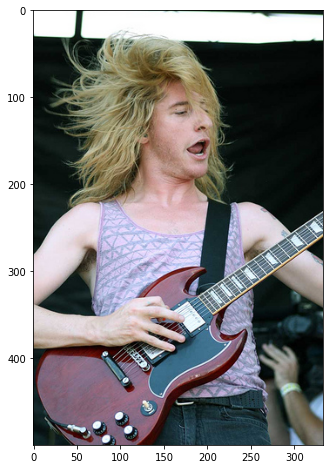

3197981073_3156963446.jpg
['electric_guitar' 'stage']


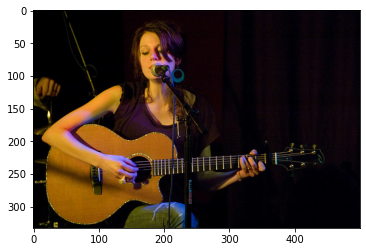

3332202255_a30c522664.jpg
['electric_guitar']


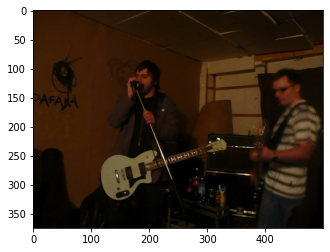

3344411431_6f4917bb2f.jpg
['electric_guitar' 'stage']


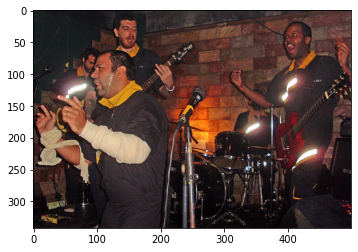

3592968286_b63c81bcd2.jpg
['electric_guitar' 'stage']


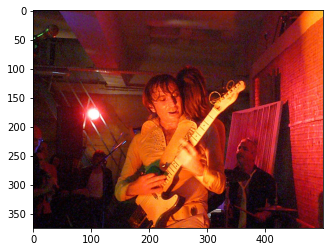

3697379772_40d831392b.jpg
['electric_guitar']


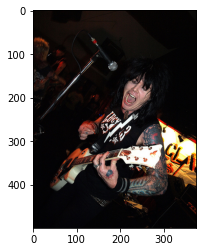

In [18]:
################ HERE CHANGE PARAMETERS
minProbablity = 0.3
columnValue = 'guitar'


################ constants
columnNameFilter = 'tags'
columnNameToList = 'imgName'

#UNIQUE LIST OF PHOTOS CONTAINGING PHRASE
def column_unique_list(df, columnNameFilter, columnValue, columnNameToList, minProbablity):
    df2 = df[df[columnNameFilter].str.contains(columnValue)]              # new df with filtered column
    df3 = df2[df2['tagProb'] > minProbablity]
    uniqueList = df3[columnNameToList].tolist()                           # convert required column values to list
    uniqueList = np.unique(uniqueList)                                    # get unique values from list
    return uniqueList

# PLOTTING MULTIPLE IMAGES

dirPathTest =  dirPathG # + '/CompressedPhotos' #uncomment if using compression

def tags_of_photo(dfTags, photoId):
    columnNameFilter= 'imgName'
    columnNameToList= 'tags'
    minProbablity = 0.2
    tags_of_photo = column_unique_list(dfTags, columnNameFilter, photoId, columnNameToList, minProbablity)

    return tags_of_photo
    

def plot_images(dirPath, imgList): # path to folder with images and list of images in that dir
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(len(imgList)):
        imgName = imgList[i]
        imgPath = dirPathTest + '/' + imgName
        img = mpi.imread(imgPath)
        plt.imshow(img)
        print(imgName)
        print(tags_of_photo(dfTags, imgName))
        
        plt.show()

imgList =  column_unique_list(dfTags, columnNameFilter, columnValue, columnNameToList, minProbablity)
plot_images(dirPathTest, imgList)


# 7. PODSUMOWANIE

Pomimo tego, że model VGG19 w otoczeniu szybko rozwiającej się dziedziny data sciene jest jak na rok 2022 modelem dojrzałym to w odczuciu autora dobrze poradził sobie z zadaniem klasyfikacji elementów repozytorium zdjęć. 

Projekt można rozbudować jeszcze o kilka modułów aby poprawić jego funkcjonalność, m.in: tłumaczenie tagów na inne języki, możlwiość używania synonimów, stworzenie interfejsu użytkownika.

Inną bolączką dzisiejszych czasów są duplikaty lub zdjęcia podobne do siebie. Rozwiązanie tego problemu można szukać również w uczeniu maszynowym. Jednym z pomysłów mógłby być model ratingowy obrazów, który określałby rating duplikatów. Model taki musiałby uwzględniać wiele parametrów zdjęcia takich jak np ostrość czy symetria obrazu.  